<h2> Core Function to Simulate any Neural Network with GPU acceleration </h2>

In [4]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
import tqdm
import scipy.io
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [5]:

import sys
np.set_printoptions(threshold=sys.maxsize)

In [6]:
class NeuralNetworkSimulator(): 
    def __init__(self, weight_matrix, batch_size = 1): 
        #Weight matrix W[i,j] -> weight from ith neuron to jth neuron
        self.batch_size = batch_size
        self.weight_matrix = weight_matrix
        self.n_neurons = weight_matrix.shape[0]
        if torch.cuda.is_available(): 
            self.weight_matrix = self.weight_matrix.cuda()
        return 
    
    def setup_neuron_and_synapse_parameters(self, tau, Vth, Vrst, tau1, tau2, I0):
        self.tau = tau
        self.Vth = Vth 
        self.Vrst = Vrst
        self.tau1 = tau1
        self.tau2 = tau2
        self.I0 = I0
        return
    
    def setup_simulation(self, dt, n_time_steps): 
        self.dt = dt
        self.n_time_steps = n_time_steps
        Ipc = torch.zeros(n_time_steps, n_time_steps)
        for i in range(n_time_steps):
            spike_time_tensor = torch.tensor([ts for ts in range(n_time_steps)])

            current_time_tensor = torch.tensor([ i for x in range(n_time_steps)])
            
            difference_tensor = -1*(current_time_tensor - spike_time_tensor)
            
            current_tensor = (self.I0)*(torch.exp(difference_tensor*dt/(self.tau1)) - torch.exp(difference_tensor*dt/(self.tau2)))
         
            Ipc[i, :] = current_tensor
            Ipc[i, i:] = 0
            pass
        self.Ipc = Ipc
        return
    
    def setup_storage_matrices(self, dt, n_time_steps): 
        self.spike_time_matrix = torch.zeros(self.batch_size, self.n_neurons, n_time_steps)
        self.current_I_through_neuron = torch.zeros(self.batch_size, 1, self.n_neurons)
        self.voltage = torch.zeros(self.batch_size, self.n_neurons)
        self.voltage[:] = self.Vrst
        self.all_voltage = torch.zeros(self.batch_size, n_time_steps, self.n_neurons)
        self.all_voltage[:] = self.Vrst
        self.Iin = torch.zeros(self.batch_size, self.n_neurons)
        self.Ipc_time_index = torch.zeros(n_time_steps) 
        if torch.cuda.is_available():
            self.spike_time_matrix = self.spike_time_matrix.cuda()
            self.current_I_through_neuron = self.current_I_through_neuron.cuda()
            self.voltage = self.voltage.cuda()
            self.Iin = self.Iin.cuda()
            self.Ipc_time_index = self.Ipc_time_index.cuda()
        return
    
    def reset_simulation(self):
        self.spike_time_matrix[:] = 0 
        self.current_I_through_neuron[:] = 0 
        self.voltage[:] = self.Vrst
        self.all_voltage[:] = self.Vrst
        self.Iin[:] = 0
        self.Ipc_time_index[:] = 0 
        return 

    def give_input_spike(self, input_spike_matrix):
        assert input_spike_matrix.shape[0] == self.batch_size
        self.spike_time_matrix[:, :, :] = input_spike_matrix
        if torch.cuda.is_available():
            self.spike_time_matrix = self.spike_time_matrix.cuda()
        return
    
    def run_simulation(self):

        Aup = 0.01
        Adown = -0.02
        self.all_weights = torch.zeros(self.n_time_steps,self.n_neurons,self.n_neurons)
        
        self.all_weights[0,:,:] = weight_matrix 
        
        
        
        for time_step in tqdm.tqdm(range(self.n_time_steps)):
            self.voltage = self.voltage*(1 - self.dt/self.tau) + self.Iin*self.dt
            condition = self.voltage < self.Vrst
            self.voltage[condition] = self.Vrst
            condition = self.voltage >= self.Vth
            slice_of_spike_time = self.spike_time_matrix[:, :, time_step]
            slice_of_spike_time[condition] = 1
            self.spike_time_matrix[:, :, time_step] = slice_of_spike_time
            self.voltage[condition] = self.Vrst
            self.all_voltage[:, time_step, :] = self.voltage[:, :]
            
            self.all_weights[time_step,:,:] = self.weight_matrix
            
            
            for i in range(self.batch_size):
                spiked_neuron = np.where(condition[i])[0]
                    
                
                for j in range(1,20):
                    if (time_step-j)>0:
                        pre_spiked_neuron = self.spike_time_matrix[i,:,time_step-j]
                      
                        
                       
                        pre_spiked_neuron = np.where(pre_spiked_neuron)[0]
                        
                        

                        for k in range(len(spiked_neuron)):
                
                                        
                            for l in range(len(pre_spiked_neuron)):
                                 if weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]]>0:
                                    weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]] =  weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]] + (weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]]*Aup*np.exp(-j/20))
                                    if weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]] > 8:
                                        weight_matrix[pre_spiked_neuron[l],spiked_neuron[k]] = 8
               
                for j in range(1,20):
                    
                    if (self.n_time_steps-1) > time_step+j:
                        post_spiked_neuron = self.spike_time_matrix[i,:,time_step+j]
                        post_spiked_neuron = np.where(post_spiked_neuron)[0]

                        for k in range(len(spiked_neuron)):
                            for l in range(len(post_spiked_neuron)):
                                if weight_matrix[post_spiked_neuron[l],spiked_neuron[k]]>0:
                                    weight_matrix[post_spiked_neuron[l],spiked_neuron[k]] =  weight_matrix[post_spiked_neuron[l],spiked_neuron[k]] + (weight_matrix[post_spiked_neuron[l],spiked_neuron[k]]*Adown*np.exp(-j/22))
                                    if weight_matrix[post_spiked_neuron[l],spiked_neuron[k]] < 0:
                                        weight_matrix[post_spiked_neuron[l],spiked_neuron[k]] = 0.001
                                    
                
                                    
                    
                    
                
            
                
                
            
            
            
            self.Ipc_time_index[:] = self.Ipc[time_step, :]
            self.current_I_through_neuron[:, 0, :] = torch.matmul(self.spike_time_matrix, self.Ipc_time_index)
            self.Iin[:, :] = torch.matmul(self.current_I_through_neuron, self.weight_matrix)[:, 0, :]
        return

To Do: 
1. Put up a progress bar to show progress of loop
2. Modify system to parallelize multiple simulations
3. Add support for refractory time in neurons and synapses

<h2> Simulating a two neuron network as an example </h2>

In [7]:
weight_matrix = torch.zeros([2, 2])
weight_matrix[0,1] = 6
weight_matrix[1,1] = 6
weight_matrix[0,0] = 6
weight_matrix[1,0] = 6



In [8]:
new_network = NeuralNetworkSimulator(weight_matrix, 5)

In [9]:
new_network.setup_neuron_and_synapse_parameters(tau = 64*pow(10, -3), Vth = 20, Vrst = 0, tau1 = 8*pow(10, -3), tau2 = 4*pow(10,-3), I0 = 250)

In [10]:
new_network.setup_simulation(dt = pow(10, -3), n_time_steps = 1000)
new_network.setup_storage_matrices(dt = pow(10, -3), n_time_steps = 1000)

In [11]:
new_network.reset_simulation()
input_spikes = torch.zeros(5, 2, 1000)
for i in range(1000): 
    if i % 15 == 0: 
        input_spikes[1, 0, i] = 1
        
new_network.give_input_spike(input_spikes)

In [12]:
np.where(new_network.spike_time_matrix[1,1,:])[0]

array([], dtype=int64)

In [13]:
np.where(new_network.spike_time_matrix[1,0,:])[0]

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375,
       390, 405, 420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570,
       585, 600, 615, 630, 645, 660, 675, 690, 705, 720, 735, 750, 765,
       780, 795, 810, 825, 840, 855, 870, 885, 900, 915, 930, 945, 960,
       975, 990], dtype=int64)

In [14]:
new_network.run_simulation()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.68it/s]


In [15]:
new_network.all_voltage.shape, new_network.spike_time_matrix.shape, new_network.current_I_through_neuron.shape

(torch.Size([5, 1000, 2]), torch.Size([5, 2, 1000]), torch.Size([5, 1, 2]))

In [16]:
print(weight_matrix)

tensor([[5.3019, 5.3019],
        [6.0000, 6.0000]])


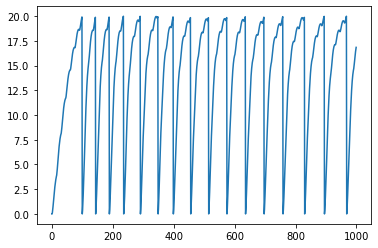

In [17]:
plt.plot(new_network.all_voltage[1, :, 1])

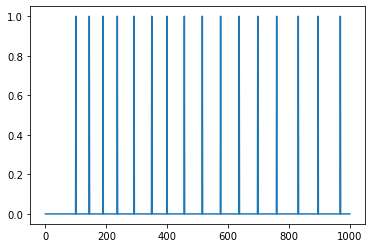

In [18]:
plt.plot(new_network.spike_time_matrix[1, 1, :].cpu())

In [19]:
new_network.spike_time_matrix[1, 0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

<h2> Setting up liquid state machine connections </h2>

In [20]:
fan_in = 4
Wine = 8
Wini = -8
n_input_channels = 77

f_excitatory = 0.85
K_values = {"ee": 0.45, "ei" : 0.3, "ie" : 0.6, "ii" :0.15} 
W_values ={"ee": 3, "ei": 6, "ie" : -2, "ii" : -2}
lambda_value =  2

alpha_res = 0.2

In [21]:
n_neurons = [5, 5, 5]
# Define a neuron coordinate grid, Map each neuron to either being e or i
number_of_neurons = 1
for neuron_number in n_neurons: number_of_neurons = number_of_neurons*neuron_number

type_of_neuron = ['i' for i in range(number_of_neurons)]


excitatory_list = list(random.sample(range(number_of_neurons), int(f_excitatory*number_of_neurons)))


for excitatory_indice in excitatory_list: type_of_neuron[excitatory_indice] = 'e'



neuron_coordinate_list = []
count = 0 
for z in range(n_neurons[2]): 
    for y in range(n_neurons[1]):
        for x in range(n_neurons[0]): 
            neuron_coordinate_list = neuron_coordinate_list + [[x,y,z]]
            pass
        pass
    pass

# Create an reservoir connection matrix factoring in k_list, weights and lambda - probability of connections
weight_matrix_res = torch.zeros(number_of_neurons, number_of_neurons)
number_of_connections = 0
for i in tqdm.tqdm(range(number_of_neurons)): 
    for j in range(number_of_neurons): 
        if i == j:continue
        n1_coordinate = neuron_coordinate_list[i]
        n2_coordinate = neuron_coordinate_list[j]
        connection_type = type_of_neuron[i] + type_of_neuron[j]
        k_value = K_values[connection_type]
        d_squared = float(np.sum(np.power((np.array(n1_coordinate) - np.array(n2_coordinate)), 2)))
        prob_of_connection =k_value*np.exp(-1*d_squared/(lambda_value**2))
        if prob_of_connection > random.uniform(0,1): 
            weight_matrix_res[i, j] = W_values[connection_type]
            number_of_connections += 1
            pass
        pass
    pass

weight_matrix_res = alpha_res*weight_matrix_res
# Create the input to reservoir connections using fan_in and Wine and Wini
total_neurons_to_simulate = number_of_neurons + n_input_channels
weight_matrix = torch.zeros(total_neurons_to_simulate, total_neurons_to_simulate)
weight_matrix[n_input_channels:, n_input_channels:] = weight_matrix_res

for i in range(n_input_channels):
    connection_list = np.array(list(random.sample(range(number_of_neurons), fan_in))) + n_input_channels

    for connection in connection_list: 
        if connection < n_input_channels: print("This connection is going back into the input channel!!!") 
        if random.uniform(0,1) > 0.5:
            weight_matrix[i, connection] = Wine
        else: 
            weight_matrix[i, connection] = Wini
        pass
    pass

# The first n_input_channel neurons are input neurons and the rest are reservoir neurons

100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 533.50it/s]


In [22]:
np.where(weight_matrix > 7)

(array([ 0,  1,  1,  1,  2,  3,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,  9,
        10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 15, 15, 15, 16, 16, 17,
        17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 23, 23, 23, 24, 24, 25, 25,
        26, 26, 26, 27, 28, 28, 29, 29, 30, 32, 32, 33, 33, 33, 34, 34, 34,
        35, 35, 36, 37, 37, 37, 38, 38, 38, 40, 40, 41, 41, 41, 42, 42, 42,
        44, 44, 45, 45, 45, 45, 46, 46, 47, 48, 49, 49, 49, 50, 51, 51, 52,
        53, 54, 54, 54, 55, 56, 56, 57, 57, 57, 57, 58, 58, 58, 59, 60, 60,
        61, 62, 62, 63, 63, 63, 64, 64, 65, 65, 66, 66, 66, 66, 67, 67, 67,
        68, 68, 68, 68, 69, 69, 70, 70, 70, 71, 73, 73, 73, 74, 75, 75, 76],
       dtype=int64),
 array([100, 156, 157, 182, 118, 194, 146, 187, 189, 138,  94, 158, 148,
         79, 108, 151, 197,  77, 145,  83, 186, 192, 171, 184, 118, 187,
        196, 179,  88, 101, 124, 104, 178, 107, 176, 138, 198, 169, 171,
        128, 133,  93, 129, 156,  91, 101, 158, 159, 179,  89, 166, 153,
  

<h2> Setting up the input signal </h2>

In [23]:
mat = scipy.io.loadmat('data_to_export.mat')
df_data = pd.DataFrame(columns = ["Spike Data", "Speaker", "Type"])
df_data["Spike Data"] = mat["x"]["S"][0]
df_data["Speaker"] = [np.squeeze(element) for element in list(mat["x"]["spk"][0])]
df_data["Type"] = [np.squeeze(element) for element in list(mat["x"]["type"][0])]
max_time_step_length = 0 


for i in range(len(df_data)):
    max_time_step_length  = max(max_time_step_length, df_data["Spike Data"][i].shape[1])
print(np.squeeze([df_data["Spike Data"][1].todense()[1]]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

<h2> Generating the liquid response </h2>

In [24]:
dt = pow(10, -3) 
n_time_steps = max_time_step_length

In [25]:
batch_size = 100
new_network = NeuralNetworkSimulator(weight_matrix, batch_size)
new_network.setup_neuron_and_synapse_parameters(tau = 64*pow(10, -3), Vth = 20, Vrst = 0, tau1 = 8*pow(10, -3), tau2 = 4*pow(10,-3), I0 = 250)
new_network.setup_simulation(dt = dt, n_time_steps = n_time_steps)
print(new_network.Ipc)
new_network.setup_storage_matrices(dt = dt, n_time_steps = n_time_steps)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.9240,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [43.0675, 25.9240,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 25.9240,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 43.0675, 25.9240,  0.0000]])


In [ ]:
n_data_samples = len(df_data)
liquid_response_matrix = torch.zeros(n_data_samples, number_of_neurons + n_input_channels)
start = 0 
end = 0 
input_matrix = torch.zeros(batch_size, number_of_neurons  + n_input_channels, n_time_steps)
while end < n_data_samples:
    if end%500 == 0: 
        print("Percentage Completed: " + str(end*100/n_data_samples))
    end = start + batch_size
    end = min(end, n_data_samples)
    for i in range(batch_size):
        index = start + i
        if index == n_data_samples: 
            break
        input_spike_data = df_data["Spike Data"][index]
        input_matrix[i, :n_input_channels, : (input_spike_data).shape[1]] = torch.Tensor(input_spike_data.todense())
    new_network.reset_simulation()
    new_network.give_input_spike(input_matrix)
    new_network.run_simulation()
    liquid_response = new_network.spike_time_matrix.sum(2)
    liquid_response_matrix[start:start + batch_size, :] = liquid_response[:end-start, : ]
    input_matrix[:] = 0 
    start = end

Percentage Completed: 0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2510/2510 [04:38<00:00,  9.02it/s]


Percentage Completed: 2.6263262947788633


 13%|█████████▉                                                                     | 315/2510 [00:36<05:15,  6.95it/s]

<h2> Creating the readout layer </h2>

In [ ]:
output_liquid_matrix = np.array(liquid_response_matrix)
target_matrix = np.array([spoken_word for spoken_word in list(df_data["Type"])])

In [ ]:
(output_liquid_matrix[:, :77].sum()/77)/(output_liquid_matrix[:, 77:].sum()/225)

In [ ]:
dict_of_accuracies = {}
n_tests = 5
train_accuracy = 0 
test_accuracy = 0 
for i in range(n_tests): 
  X_train, X_test, y_train, y_test = train_test_split(output_liquid_matrix[:, :77], target_matrix, test_size=0.2, random_state = 42 + random.randint(0, 30))
  clf = make_pipeline(LogisticRegression())
  clf.fit(X_train, y_train)
  train_accuracy += clf.score(X_train, y_train)
  test_accuracy += clf.score(X_test, y_test)

dict_of_accuracies['only input'] = {'train': train_accuracy*100/n_tests, 'test': test_accuracy*100/n_tests}

n_tests = 5
train_accuracy = 0 
test_accuracy = 0 
for i in range(n_tests): 
  X_train, X_test, y_train, y_test = train_test_split(output_liquid_matrix[:, 77:], target_matrix, test_size=0.2, random_state = 42 + random.randint(0, 30))
  clf = make_pipeline(LogisticRegression())
  clf.fit(X_train, y_train)
  train_accuracy += clf.score(X_train, y_train)
  test_accuracy += clf.score(X_test, y_test)

dict_of_accuracies['only liquid'] = {'train': train_accuracy*100/n_tests, 'test': test_accuracy*100/n_tests}


n_tests = 5
train_accuracy = 0 
test_accuracy = 0 
for i in range(n_tests): 
  X_train, X_test, y_train, y_test = train_test_split(output_liquid_matrix[:, :], target_matrix, test_size=0.2, random_state = 42 + random.randint(0, 30))
  clf = make_pipeline(LogisticRegression())
  clf.fit(X_train, y_train)
  train_accuracy += clf.score(X_train, y_train)
  test_accuracy += clf.score(X_test, y_test)

dict_of_accuracies['input and liquid'] = {'train': train_accuracy*100/n_tests, 'test': test_accuracy*100/n_tests}



In [ ]:
print("***********************************Only Input used for Training*****************************")
print("train score = " + str(dict_of_accuracies['only input']['train']))
print("test score = " + str(dict_of_accuracies['only input']['test']))
print("********************************************************************************************")

print("***********************************Only Liquid used for Training*****************************")
print("train score = " + str(dict_of_accuracies['only liquid']['train']))
print("test score = " + str(dict_of_accuracies['only liquid']['test']))
print("********************************************************************************************")

print("***********************************Input and Liquid used for Training*****************************")
print("train score = " + str(dict_of_accuracies['input and liquid']['train']))
print("test score = " + str(dict_of_accuracies['input and liquid']['test']))
print("********************************************************************************************")